## RQ2 Text Analysis

General plan:
- Follow a similar approach to the Chai-Allah "Data Mining..." paper to create clusters from the data
    - Just use tokenisation first, if 2 big then use lemmatisation
    - for now, just use all words (don't worry about filtering for high frequency words)
    - Use a German version of the word2vec model (see what the baroni one is based on and try to find a German equivalent)
    - use k-means or ward's for the clustering

Steps:
1. Initial Cleaning
2. Language Handling 
3. Tokenisation 
4. Filtering & Lemmatisation (remove stop words, lemmatise, convert to lowercase)
5. Semantic analysis (word2vec)
6. Clustering


In [2]:
# SETUP

# Import packages
import pandas as pd
import numpy as np
import pickle

import spacy 
from langdetect import detect
from deep_translator import GoogleTranslator
from collections import Counter
from gensim.models import KeyedVectors  # requires scipy version 1.12 (anything newer doesn't work)


from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from wordcloud import WordCloud


### Step 1: Initial Cleaning

General text preparation to get the data in a format which works for translation and for use with spacy.

Decided not to use the comments as there is no guarantee the comments are an expression of someone's perception about the trail/landscape (they might just be saying the trail looks nice from the original posters description, they might be commenting on the directions, etc)

In [ ]:
# STEP 1: LOAD & CLEAN

# Load the master CSV from rq2_step1_data_collection
master = pd.read_csv("./processing/master.csv")

# Add ['None'] to any blank rows
# this is necessary for the next step, but then they will be removed later
master.fillna("['None']", inplace=True)

# Extract the description and captitions and combine them into a single column
raw_text = pd.DataFrame()
raw_text["desc_capt"] = master["description text"] + " " + master["photo_captions"]

# Now remove all the ['None'] text from both columns
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\['None'\]", "", regex=True)

# Remove certain special characters
sp_char = ["[", "]", "'", "|", "\\", "/", "+", "="]

for char in sp_char:
    raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(char,"")

# This is to address a specific issue in one of the entries (replace with space)
raw_text["desc_capt"] = raw_text["desc_capt"].str.replace(r"\n", " ", regex=True)

# Create a list from the column
raw_text_list = raw_text["desc_capt"].astype(str).values.tolist()

# Convert entries which are just a space (" ") to be empty ("")
raw_text_list = [x.strip(' ') for x in raw_text_list]

# Remove all empty entries
raw_text_list = list(filter(None, raw_text_list))

# Check
raw_text_list

['Schönmünzach',
 'Altenheim',
 'Wanderung vom Goldenen Anker in Zwingenberg nahe der Neckarbrücke nach Eberbach über Burg Stolzeneck Zwingenberg Brücke, Zwingenberg Burg, Ziegen, Zwingenberg Burg, 1, Umgefallener Baum, 2, 3, Abzweigung, Abzweigung, Schlossblick, Bergbrunnen, Wildrosen, Abzweigung, Reihersee, Abzweigung, Ausblick auf den Neckar, Abzweigung rechts, Abzweigung, 4, Burg Stolzeneck, Burg Stolzeneck, Wegweiser, Bachlauf, Fingerhut, 5, Aussicht, Abzweigung Richtung Rockenau, Steinbruch, Abzweigung rechts, Blick auf Rockenau über Friedhof, Abzweigung, Blick auf Eberbach, Zur Stadt, Foto, Statue, Kirche',
 '3.5 miles down hill. Some water. 3.5 miles back up hill. Photo, Photo',
 'Ruta circular sencilla. El desnivel real es de 420m (error en el altímetro del GPS). En el punto de partida se puede dejar bien el coche al principio del camino. En el lado de la pista justo pasada la mesa de pícnic. Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto',
 'Alte

### Step 2: Language Handling: Translate to German

As the vast majority of text is in German, I will use this as the base language. I have the option now to either remove anything not in German or to translate it. Although translation is not ideal (maybe some of original meaning is lost/altered), I think this is a better option than just removing the other languages entirely. So here I will tranlsate everything into German. 

As there were some issues with this at first, Ross suggested only translating when there are enough words, for example at least 3 unique tokens. Any language detection algorithm will struggle more when there are only 1 or 2 unique words to go on. This requires some preliminary tokenisation to get the count of unique tokens. **I then discard the text for a trail if it has less than 3 unique tokens (most of these are places where people have used the "Foto" placeholder)**


langdetect package: https://anaconda.org/conda-forge/langdetect 
- Use to check if already German

deep-translator package: https://pypi.org/project/deep-translator/
- Using Google Translate as it doesn't require API key (DeepL requires API key)


count_dict = dict(zip(raw_text_list, unique_token_counts))

In [4]:
# STEP 2: FILTER OUT SHORT TEXTS

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the unique token counts for each trail
unique_token_counts = []

# Tokenise the text for each trail & count the number of unique tokens for each trail
for trail_text in raw_text_list:
    doc = nlp(trail_text)
    tokens = [token.text.lower() for token in doc if not token.is_punct and not token.is_space]
    unique_tokens = set(tokens)
    unique_token_counts.append(len(unique_tokens))

# Combine results into a df
raw_text_counts = pd.DataFrame()
raw_text_counts["text"] = raw_text_list
raw_text_counts["unique_tokens"] = unique_token_counts

# Filter df to only include rows where unique_tokens >= 3
raw_text_counts = raw_text_counts.loc[(raw_text_counts["unique_tokens"] >= 3)]

# Save the text column as a list for use in the next steps
raw_text_3token_list = raw_text_counts["text"].astype(str).values.tolist()

# Check
#raw_text_3token_list


['Wanderung vom Goldenen Anker in Zwingenberg nahe der Neckarbrücke nach Eberbach über Burg Stolzeneck Zwingenberg Brücke, Zwingenberg Burg, Ziegen, Zwingenberg Burg, 1, Umgefallener Baum, 2, 3, Abzweigung, Abzweigung, Schlossblick, Bergbrunnen, Wildrosen, Abzweigung, Reihersee, Abzweigung, Ausblick auf den Neckar, Abzweigung rechts, Abzweigung, 4, Burg Stolzeneck, Burg Stolzeneck, Wegweiser, Bachlauf, Fingerhut, 5, Aussicht, Abzweigung Richtung Rockenau, Steinbruch, Abzweigung rechts, Blick auf Rockenau über Friedhof, Abzweigung, Blick auf Eberbach, Zur Stadt, Foto, Statue, Kirche',
 '3.5 miles down hill. Some water. 3.5 miles back up hill. Photo, Photo',
 'Ruta circular sencilla. El desnivel real es de 420m (error en el altímetro del GPS). En el punto de partida se puede dejar bien el coche al principio del camino. En el lado de la pista justo pasada la mesa de pícnic. Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto, Foto',
 'Zwingenberg - Eberbach Foto, Foto, 

DUPLICATE HANDLING

At this point I noticed sometimes there were duplicates in the text. I checked the original master csv and saw that sometimes the same trail is listed twice with different URLs. Sometimes there are slight differences (for example one being classified as road bike, and the other as "unspecified", or having slightly different titles), but the text descriptions &/or captions are the same. So I guess this is an issue with a user uploading the same thing twice or a glitch with Wikiloc.

To handle this, if the texts are the exactly same I remove one of them.

In [5]:
# STEP 2: DUPLICATE TEXT HANDLING

# Check for duplicates and preserve order
seen = set()
raw_text_3token_list_unq = []
for item in raw_text_3token_list:
    if item not in seen:
        seen.add(item)
        raw_text_3token_list_unq.append(item)

raw_text_3token_list_unq

len(raw_text_3token_list_unq)

1679

For the next step I originally tried using langdetect to detect whether the text was already in German and then passing anything not in German to deep_translator for the actual translation. I found this didn't always work that well and had issues with it failing to translate or translating when it didn't need to. I therefore tried an alternate approach where deep_translator is used for everything (the auto language detection is used and then everything that is not already German is translated to German; text already in German is skipped).

I compared both approaches for a subset of the data (Bremen, Niedersachsen and Saxony-Anhalt trails - 289 trails total) and found that the success rate was better for the deep_translator only approach, so I have continued with this approach. See details below.

| Category                         | Combo Lang Detect & Deep Translator | Deep Translator Only |
| -------------------------------- | ----------------------------------- | -------------------- |
| DE correctly recognised          | 201                                 | 211                  |
| successful translation           | 33	                                 | 48                   |
| mixed lang - unchanged	       | 5	                                 | 3                    |
| mixed lang - some issues	       | 9	                                 | 6                    |
| unneeded translation	           | 6	                                 | 4                    |
| failed to translate	           | 14	                                 | 6                    |
| incorrect translation	           | 7	                                 | 4                    |
| unneeded & incorrect translation | 14 	                             | 7                    |
| Total	                           | 289	                             | 289                  |
| Success Rate	                   | 80.97%                              | 89.62%               |



Also for the next step I ran into problems where the translation would fail because there were too many characters for an individual trail (the error message was: Text length need to be between 0 and 5000 character). I've therefore added an additional step here to basically cut off anything after 5000 characters. In case this results in a partial word at the end, I also remove the last word/partial word to ensure that there isn't an incomplete token later (I split the text from the right according to where the first white space is and then remove everything after that white space).

First I run a count to check how many trails would be affected by the truncating - then I truncate the text and check again to make sure there are no trails with >5000 characters.


In [16]:
# STEP 2: COUNT >5000

# Create starting point for count
count_5000 = 0

# Count trails with more than 5000 characters
for trail_text in raw_text_3token_list_unq:
    if len(trail_text) > 5000:
        count_5000 += 1

# Show the count
count_5000

1

In [27]:
# STEP 2: TRUNCATE >5000

# Create a new list for the truncated trail text
raw_text_3token_list_unq_trunc = []

# Truncate any text greater than 5000 characters
# Also remove the last word in case it's only a partial word
for trail_text in raw_text_3token_list_unq:
    if len(trail_text) > 5000:
        trail_text_trunc = trail_text[:5000]
        trail_text_trunc = trail_text_trunc.rsplit(' ', 1)[0]
        raw_text_3token_list_unq_trunc.append(trail_text_trunc)
    else:
        raw_text_3token_list_unq_trunc.append(trail_text)

# Check to make sure removal was successful
# Create starting point for check count
check_5000 = 0

# Count trails with more than 5000 characters in the new list
for trail_text in raw_text_3token_list_unq_trunc:
    if len(trail_text) > 5000:
        check_5000 += 1

# Show the check count
check_5000


0

In [ ]:
# STEP 2: TRANSLATE TO GERMAN (RUN ONCE)
# TAKES ABOUT 15 MIN

raw_text_de = []
translated_count = 0
skipped_count = 0

# Use deep translator to automatically detect language and translate to German
# If German is detected it will skip the entry (ie. it will not try to translate)
for trail_text in raw_text_3token_list_unq_trunc:
    translated = GoogleTranslator(source='auto', target='de').translate(text=trail_text)

    # Check if translation changed anything
    if translated.strip() == trail_text.strip():
        skipped_count += 1
    else:
        translated_count += 1

    raw_text_de.append(translated)

print(f"Translated: {translated_count}")
print(f"Skipped (already German or unchanged): {skipped_count}")
print(f"Percent translated: {round(((translated_count/(translated_count+skipped_count))*100),2)}")



Translated: 691
Skipped (already German or unchanged): 988
Percent translated: 41.16


In [29]:
# STEP 2: SAVE TRANSLATED TEXT

pickle.dump(raw_text_de, open("./processing/raw_text_de.p", "wb"))

In [30]:
# STEP 2: LOAD TRANSLATED TEXT

raw_text_de = pickle.load(open("./processing/raw_text_de.p", "rb"))

### Step 3: Tokenisation 

German spacy model options: https://spacy.io/models/de 

de_core_news_sm (I've installed this one so far)
de_core_news_md
de_core_news_lg
de_dep_news_trf

Which is best to use?

**REVISIT THIS LATER**


In [31]:
# STEP 3: TOKENISATION

# Load the spacy model
nlp = spacy.load("de_core_news_sm")

# Create an empty list to store the tokens
doc = []

# Tokenise the raw_text input
for string in raw_text_de:
    doc.extend(nlp(string))

# Print the tokens to check
#for token in doc:
#    print(token)


### Step 4: Filtering (& Lemmatisation?)

Remove stop words, punctuation & numbers from the token list, and optionally extract the lemma for each final token.

Convert all to lower-case.

**Also:** 
- remove the word "Foto" as this is just placeholder text
- "null" is also used as a placeholder sometimes so I have included this as a stop word as well

In [59]:
# STEP 4: STOP WORDS ETC

# Add words to stop list
nlp.vocab["Foto"].is_stop = True
nlp.vocab["foto"].is_stop = True
nlp.vocab["FOTO"].is_stop = True
nlp.vocab["Fotos"].is_stop = True
nlp.vocab["Photo"].is_stop = True
nlp.vocab["null"].is_stop = True
nlp.vocab["Waypoint"].is_stop = True

# Filter out tokens that are stop words (is_stop), puncutation (is_punct), 
# numbers (is_digit & like_num) OR spaces (is_space)
# option use token.lemma_ to extract the lemma for the final tokens
filtered_tokens = [token.text for token in doc if not token.is_stop | token.is_punct | 
                   token.is_digit | token.like_num | token.is_space]

# Empty list for lower-case versions
filtered_tokens_lc = []

# Convert to lower-case 
for token in filtered_tokens:
    token_lc = token.lower()
    filtered_tokens_lc.append(token_lc)

# Check
print(filtered_tokens_lc)

['wanderung', 'goldenen', 'anker', 'zwingenberg', 'nahe', 'neckarbrücke', 'eberbach', 'burg', 'stolzeneck', 'zwingenberg', 'brücke', 'zwingenberg', 'burg', 'ziegen', 'zwingenberg', 'burg', 'umgefallener', 'baum', 'abzweigung', 'abzweigung', 'schlossblick', 'bergbrunnen', 'wildrosen', 'abzweigung', 'reihersee', 'abzweigung', 'ausblick', 'neckar', 'abzweigung', 'rechts', 'abzweigung', 'burg', 'stolzeneck', 'burg', 'stolzeneck', 'wegweiser', 'bachlauf', 'fingerhut', 'aussicht', 'abzweigung', 'richtung', 'rockenau', 'steinbruch', 'abzweigung', 'rechts', 'blick', 'rockenau', 'friedhof', 'abzweigung', 'blick', 'eberbach', 'stadt', 'statue', 'kirche', 'meilen', 'hinunter', 'wasser', 'meilen', 'hügel', 'einfache', 'kreisförmige', 'route', 'reale', 'steigung', 'beträgt', 'm', 'fehler', 'gps', '-höhenmesser', 'startpunkt', 'auto', 'beginn', 'straße', 'verlassen', 'strecke', 'píconic', '-tabelle', 'zwingenberg', 'eberbach', 'wunderschöner', 'aufstieg', 'freiburg', 'top', 'perfekten', 'panoramabli

In [60]:
# STEP 4: CHECKING SOME RESULTS? :) 

word_freq = Counter(filtered_tokens_lc)

common_words = word_freq.most_common(20)

common_words


[('weg', 185),
 ('blick', 128),
 ('aussicht', 104),
 ('parkplatz', 98),
 ('schöne', 91),
 ('wanderung', 88),
 ('entlang', 84),
 ('burg', 83),
 ('wald', 81),
 ('m', 76),
 ('rechts', 75),
 ('punkt', 74),
 ('hwn', 68),
 ('route', 66),
 ('km', 66),
 ('wegpunkt', 66),
 ('start', 65),
 ('richtung', 63),
 ('links', 63),
 ('schöner', 63)]

I think HWN stands for Harzer Wandernadel: a hiking badge system for the Harz mountains https://en.wikipedia.org/wiki/Harzer_Wandernadel

### STEP 5: Semantic analysis (word2vec)

Using the de_wiki word2vec model from https://sites.google.com/site/fritzgntr/software-resources/semantic_spaces because it is the closest one to the baroni model used in the Chai-allah paper but for German. 

The semantic spaces are provided in .rda format for R but can be export as a txt for use outside R using the following commands (in R). NOTE: I had to adjust from the instruction on the source website as it didn't account for use in gensim, which then meant I had problems with quotes and separators.

 load("C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.rda")

 write.table(de_wiki, file = "C:/Users/ninam/Documents/UZH/04_Thesis/code/nm_forest_thesis/word2vec/de_wiki.txt", row.names = TRUE, col.names = FALSE, quote = FALSE, sep = " ")
 

 Some useful notes/resources:
 - "a word embedding refers to a vector representation of a particular word or phrase in a multidimensional space" (Generally this website is helpful: https://okan.cloud/posts/2022-05-02-text-vectorization-using-python-word2vec/)
 - https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
 - https://medium.com/@denis.arvizu/text-clustering-using-word2vec-a89fbd9b9d0f

In [ ]:
# STEP 5: MODEL PREP (RUN ONCE!)

# First I need to adjust the encoding and add the header information required by gensim
# Then I can save it in gensim format for easier use

# Count rows and vector size for header info
with open("./word2vec/de_wiki.txt", encoding="ISO-8859-1") as f:
    lines = f.readlines()

num_words = len(lines)
vector_size = len(lines[0].split()) - 1

# Write in utf-8 with header info
with open("./word2vec/de_wiki_utf8_header.txt", "w", encoding="utf-8") as f:
    f.write(f"{num_words} {vector_size}\n")
    f.writelines(lines)

# Load model (from new txt file) with gensim
model = KeyedVectors.load_word2vec_format("./word2vec/de_wiki_utf8_header.txt", binary=False)

# Save the model in optimised gensim format (this will make the loading faster for next time)
model.save("./word2vec/de_wiki_final.model")

In [61]:
# STEP 5: CHECKING MODEL

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Which tokens are known versus which are missing in model?
known_tokens = [token for token in filtered_tokens_lc if token in model]
unique_known_tokens = set(known_tokens)
unique_known_count = len(unique_known_tokens)

missing_tokens = [token for token in filtered_tokens_lc if token not in model]
unique_missing_tokens = set(missing_tokens)
unique_missing_count = len(unique_missing_tokens)

# Print results
print("Total known tokens", len(known_tokens))
print("Total missing tokens", len(missing_tokens))
print("Percentage absolute missing:", round((len(missing_tokens)/(len(known_tokens)+len(missing_tokens)) *100), 2))
print("-----")
print("Unique known tokens:", unique_known_count)
print("Unique missing tokens:", unique_missing_count)
print("Percentage unique missing:", round((unique_missing_count/(unique_known_count+unique_missing_count)*100), 2))
print("-----")
print("Missing tokens:", unique_missing_tokens)



Total known tokens 16391
Total missing tokens 5224
Percentage absolute missing: 24.17
-----
Unique known tokens: 6242
Unique missing tokens: 3891
Percentage unique missing: 38.4
-----
Missing tokens: {'carolinengrube-obesexau-carolinengrube', 'umgefallener', 'haibacher', 'lebruck', 'hambachtal', 'bayern-stil', 'klingbachtal', 'jaquemod', 'abflugspunkt', 'kaiser-mineral-quelle', 'e04', 'windsborn-krater', 'fahrradstoßdämpfer', '-königsplatz', 'brandplatz', 'hohnehof', 'habichtsblick', 'pfaffenköpfe', 'caminata', 'knopfmacher', 'eigent', 'axtloh', 'mammutbaum-blick', '°', '-eisenbahn', '-personas', 'dämmerwald', 'schotterspur', 'urdonautal', 'sachsenbrunnen', '-route', 'brand-neuhages', 'schaugeurs', 'höhenst', 'hikingmap', 'öffnungszeiten', '5,8%15', 'kopfbeschränken', 'steighof', 'knieselspitze', 'nolling', 'motivwanderweg', 'waldcafe', 'herzogsteig', 'n47', '608.5m', 'sandhöhlen', 'ottofelsen', 'börners', 'elmshagen', 'rur-damms', 'beerensen', 'klöster-schleif-route', 'móngstener', 'k

In [62]:
# STEP 5: CONVERT TOKENS TO VECTORS (CREATE WORD EMBEDDINGS)

# Load model from model file
model = KeyedVectors.load('./word2vec/de_wiki_final.model')

# Create empty list to store vectors
vectors = []

# Create empty list to store valid tokens (i.e. tokens which are present in the model)
valid_tokens = []

# Store the vectors for each token
for token in filtered_tokens_lc:
    if token in model:
        vector = model[token]
        vectors.append(vector)
        valid_tokens.append(token)


**NOTE**
I thought I had to change the code above so that the tokens were grouped together by their trail (so when determining the vector it takes the context of the words in the correct trail description) - BUT I think this is actually not the way the model works: the model uses a context window of 5 when training the model to create the vectors - but once the vectors are created they are just applied on a word-by-word basis (i.e. bag of words model). The code above basically works the same as the code in this chunk - either is okay.

In [63]:
# STEP 5: COSINE SIMILARITY/DISIMILARITY

# Approximate cosine similarity (for kmeans)
normalised_vectors = normalize(vectors)


### Step 6: Clustering

I'll try it out with k-means first.

First step is to see how many clusters I should make using the elbow method.

Note I got the following error message when running this originally: *UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.* To resolve this I edited the **system environment variables** using the instructions in the first answer here: https://stackoverflow.com/questions/69596239/how-to-avoid-memory-leak-when-dealing-with-kmeans-for-example-in-this-code-i-am

Resources
- GEO881 Assignment 1, Part 2 (kmeans classification - but in R)
- https://www.w3schools.com/python/python_ml_k-means.asp
- https://medium.com/@m3redithw/wordclouds-with-python-c287887acc8b


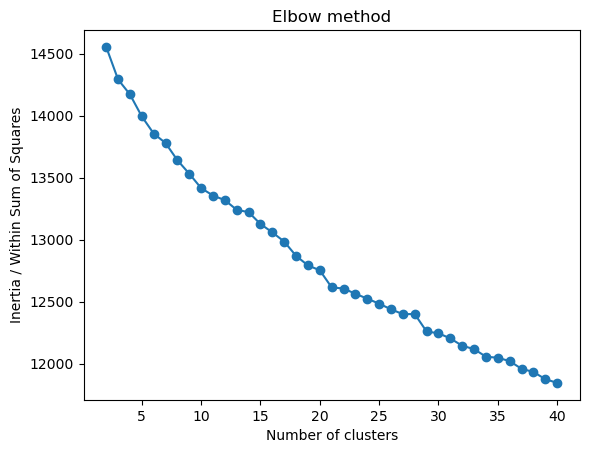

In [64]:
# STEP 6: DETERMINE NUMBER OF CLUSTERS

# Set seed for reproducible results
#np.random.seed(244)

# Create empty list to intertias (within cluster sum of squares)
inertias = []

# Test kmeans intertias/within ss for 2-40 clusters
# Random state needed for reproducible results
for k in range(2,41):
  kmeans = KMeans(n_clusters=k, max_iter=200, random_state=384)
  kmeans.fit(normalised_vectors)
  inertias.append(kmeans.inertia_)

# Generate the elbow plot
plt.plot(range(2,41), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia / Within Sum of Squares')
plt.show() 

Based on plot above - 14 clusters?

In [65]:
# STEP 6: KMEANS WITH 14 CLUSTERS

# Set seed for reproducible results
np.random.seed(11)

# Define number of clusters basedon elbow plot
n_clusters = 14

# Generate kmeans clusters and labels
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(normalised_vectors)
labels = kmeans.labels_

# Create a df with the cluster number for each token contained in the model
token_cluster_all = pd.DataFrame({"token": valid_tokens, "cluster": labels})

# Check
token_cluster_all


,token,cluster
0,wanderung,5
1,goldenen,12
2,anker,12
3,zwingenberg,4
4,nahe,9
...,...,...
16386,marienthal,6
16387,höhe,9
16388,sonne,12
16389,fast,9


In [68]:
# STEP 6: SAVE OUTPUTS FOR RQ3

pickle.dump(token_cluster_all, open("./processing/token_cluster_all.p", "wb"))

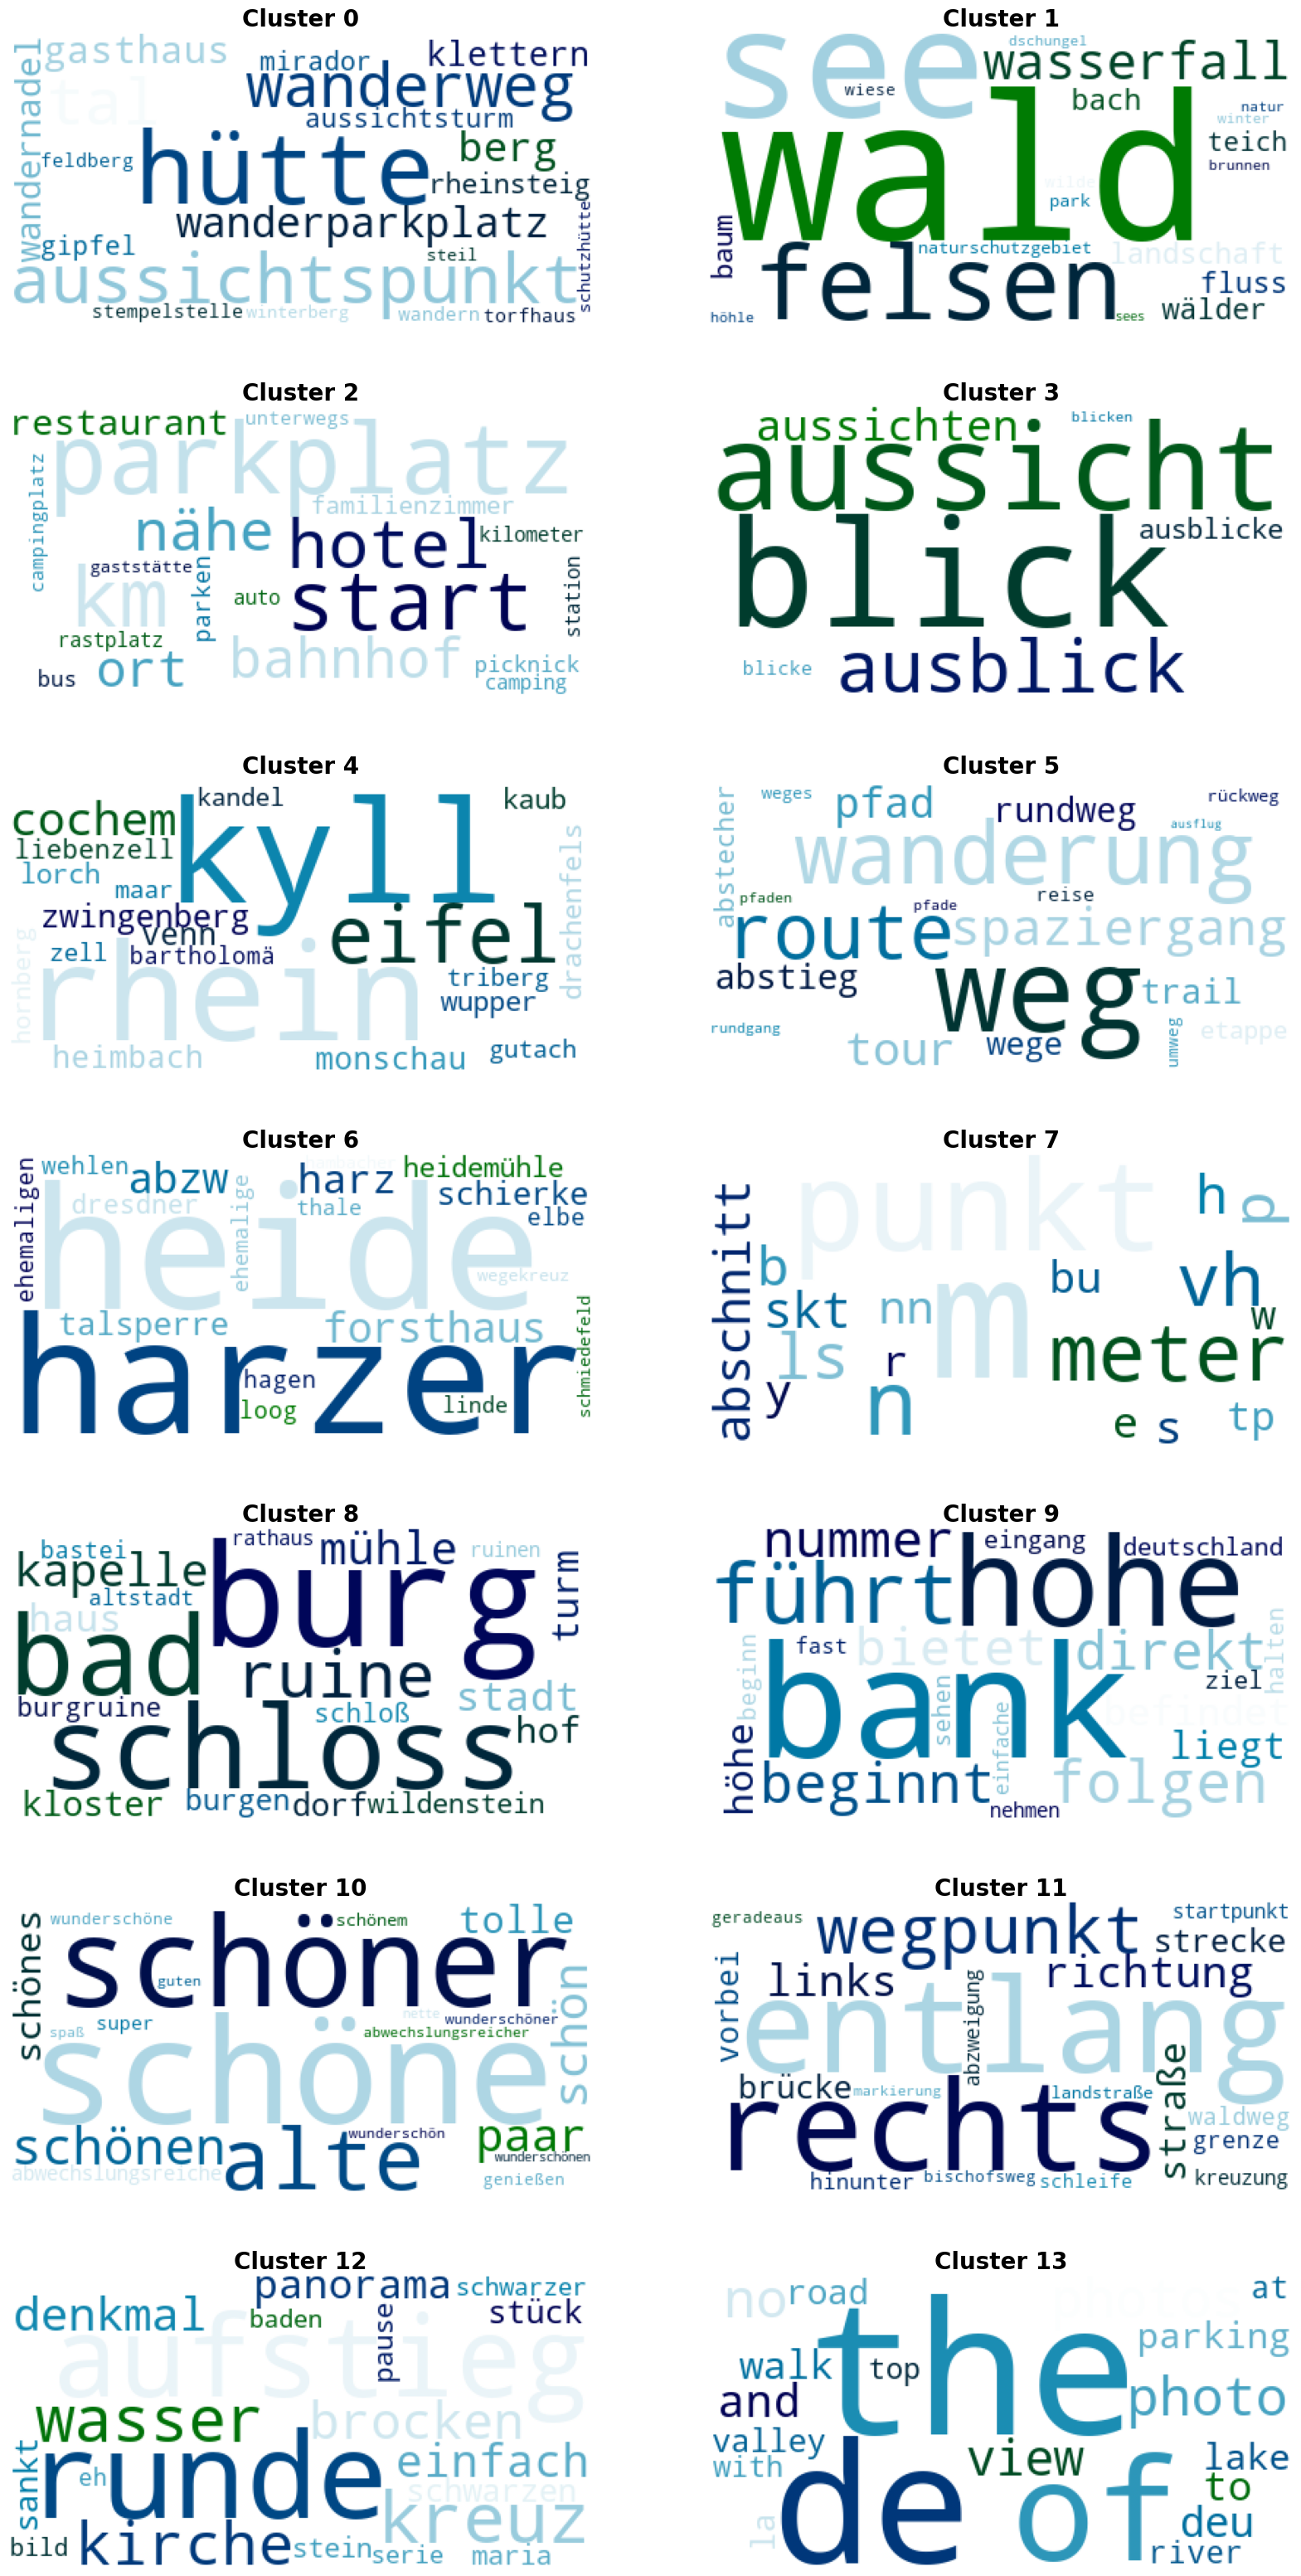

In [67]:
# STEP 6: EXPLORE CLUSTER WORD CLOUDS

# Create a function to count the token frequencies for each cluster 
def get_cluster_freq(df, clus_num):
    token_list = df.loc[df["cluster"] == clus_num, "token"]
    delimiter = " " 
    join_str = delimiter.join(token_list)
    freqs = Counter(join_str.split())
    return freqs

# Create empty lists for storing the word cloud plots 
all_wc = []

# For each cluster number (0-13) use the get_cluster_freq function to get token frequencies,
# input those frequencies into the WordCloud generator and append each wc to list
# IMPORTANT: I HAVE LIMITED TO SHOW TOP 20 TOKENS IN EACH CLUSTER
for clus_num in range(14):  
    freqs = get_cluster_freq(token_cluster_all, clus_num)
    wc = WordCloud(background_color='white', 
                   colormap='ocean', 
                   max_words=20).generate_from_frequencies(freqs)
    all_wc.append(wc)

# Create custom titles
all_titles = ["Cluster 0", "Cluster 1", 
              "Cluster 2",  "Cluster 3", 
              "Cluster 4", "Cluster 5", 
              "Cluster 6", "Cluster 7", 
              "Cluster 8", "Cluster 9",
              "Cluster 10", "Cluster 11",
              "Cluster 12", "Cluster 13"]

old_titles = ["Cluster 0 - Distances/Units", "Cluster 1 - Religion? (spiritual CES?)", 
              "Cluster 2 - Odd mix...",  "Cluster 3 - Nature Words", 
              "Cluster 4 - Placenames", "Cluster 5 - Harz placenames", 
              "Cluster 6 - Trail/Route Words", "Cluster 7 - Placemames", 
              "Cluster 8 - Old things (heritage CES?)", "Cluster 9 - Trail/Route Words",
              "Cluster 10 - Directions/Transportation", "Cluster 11 - Directions"]


# Create a figure with 14 subplots
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 40))
axes = axes.flatten()

# Iterate through word clouds and titles to plot
for i, (wc, title) in enumerate(zip(all_wc, all_titles)):
    axes[i].imshow(wc)
    axes[i].axis('off')
    axes[i].set_title(title, fontsize=20, fontweight="bold")

# Display final figure
plt.show()


